### E06

시계열(Time-Series) : 시간 순서대로 발생한 데이터의 수열
ARIMA : 안정적인 시계열임을 전제로 분석한다. 약간 비안정적이여도 가능하다.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [2]:
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

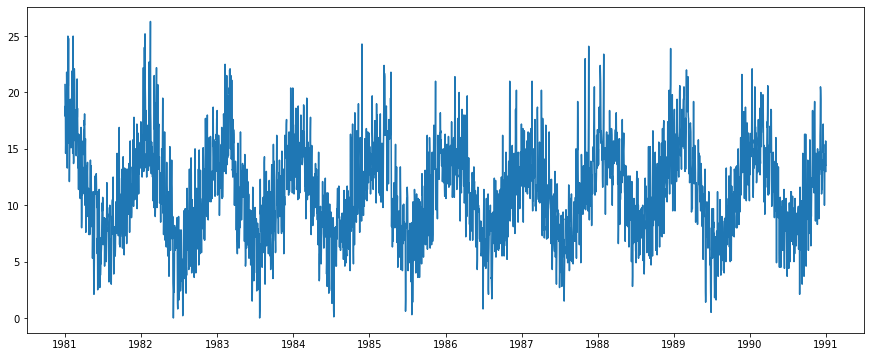

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

# time series 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

In [5]:
# 결측치 유무 확인
ts1[ts1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 결측치가 있는 데이터는 모두 삭제
# 결측치 양 옆의 값들을 이용해서 보간 대입해 준다.

Series([], Name: Temp, dtype: float64)

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')
ts1[ts1.isna()]    # 다시 NaN 확인

Series([], Name: Temp, dtype: float64)

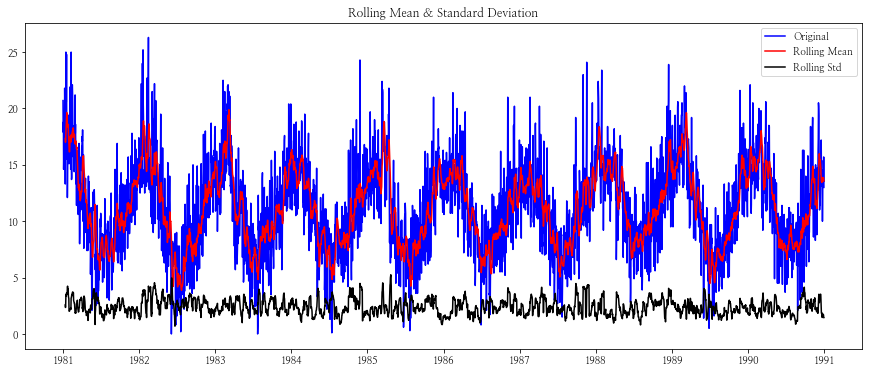

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts1, window=12)

##### 항공승객 데이터셋

In [8]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


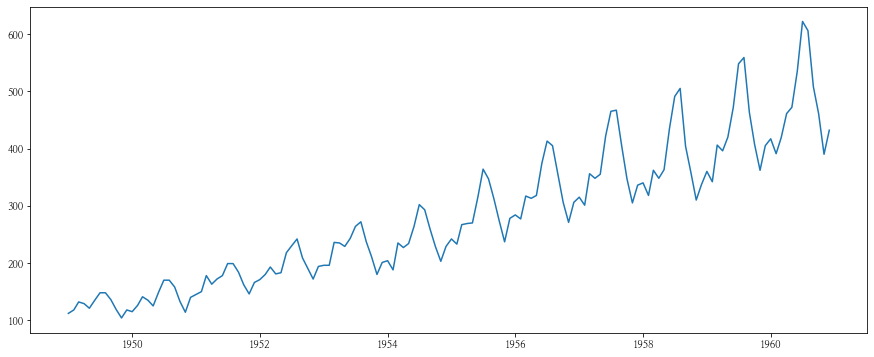

In [9]:
ts2 = df['Passengers']
plt.plot(ts2)

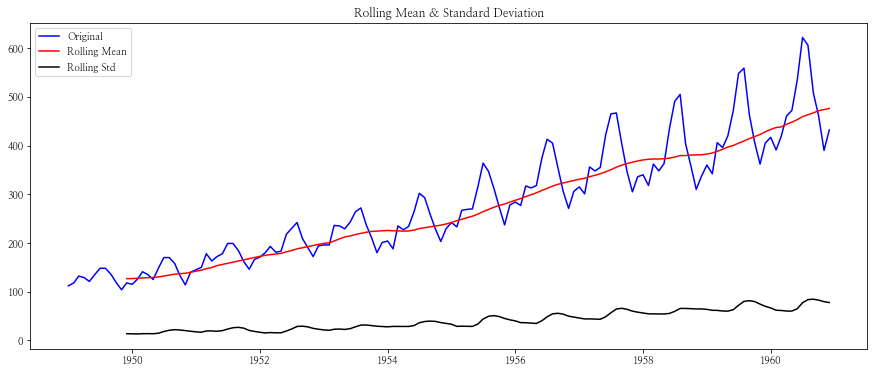

In [10]:
plot_rolling_statistics(ts2, window=12)

In [11]:
# 시계열 데이터의 안정성 테스트하기
# Augmented Dickey-Fuller Test
# - 주어진 시계열 데이터가 안정적이지 않다 (귀무가설)
# - 귀무가설 기각시 이 시계열 데이터는 안정적이다 (대립가설이 채택)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(ts1)

# 귀무가설은 이 시계열은 안정적이지 않다
# p-value가 거의 0에 가깝게 나오므로 귀무가설은 기각, 이 시계열은 안정적이다.

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [13]:
augmented_dickey_fuller_test(ts2)

# p-value가 거의 1에 가까우므로 귀무가설은 채택, 이 시계열은 안정적이라 말할 수 없다.

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


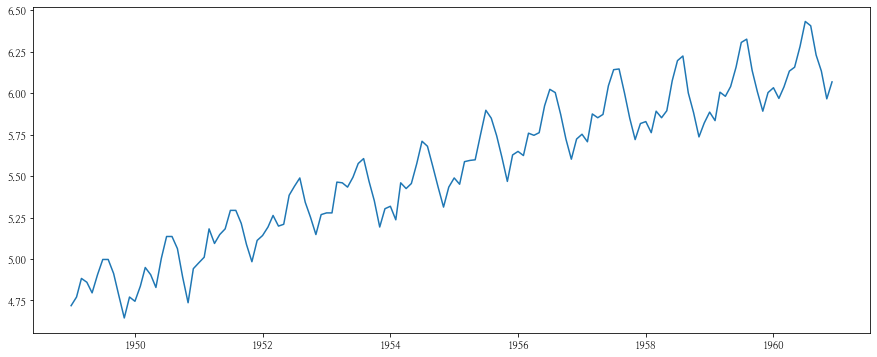

In [14]:
# 안정적이지 않은 시계열을 안정적인 형태로 만들기
# 1. 데이터를 가공/변형하는 방법
# 2. 시계열 분해 기법

# 시간 추이에 따라 분산이 점점 커지는 시계열의 경우 로그함수로 변환해주면 좋다.
ts_log = np.log(ts2)
plt.plot(ts_log)

In [15]:
# 안정성 테스트해보기
augmented_dickey_fuller_test(ts_log)

# p-value가 0.42정도로 떨어진다.

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


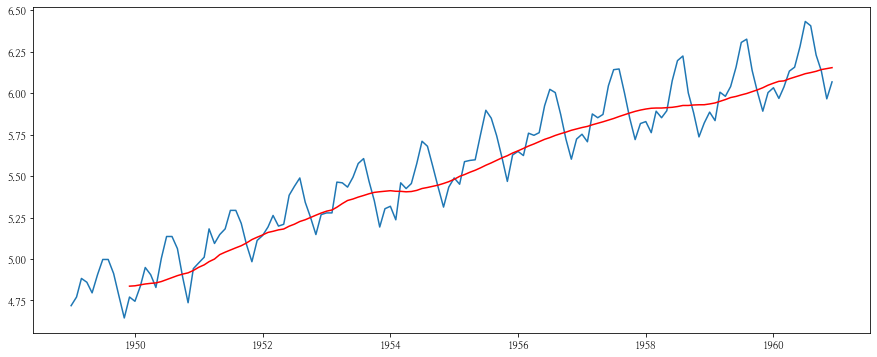

In [16]:
# 시간 추이에 따라 나타나는 평균값 변화를 트렌드(Trend)라 한다.

# rolling mean?
moving_avg = ts_log.rolling(window=12).mean()  # moving average를 구해서 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [17]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [18]:
# Movinng Average계산시(windoww size=12)앞의 11개 데이터를 계산되지 않으므로
# 결측치는 에러를 발생시키므로 데이터셋에서 빼준다.

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


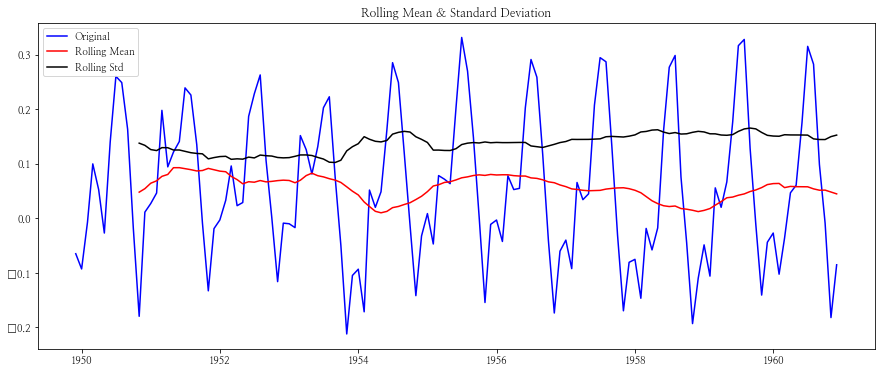

In [19]:
plot_rolling_statistics(ts_log_moving_avg)

In [20]:
augmented_dickey_fuller_test(ts_log_moving_avg)

# p-value가 0.02수준으로 떨어진다.
# Moving Average계산시 window값은 12로 지정해줘야 한다.

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


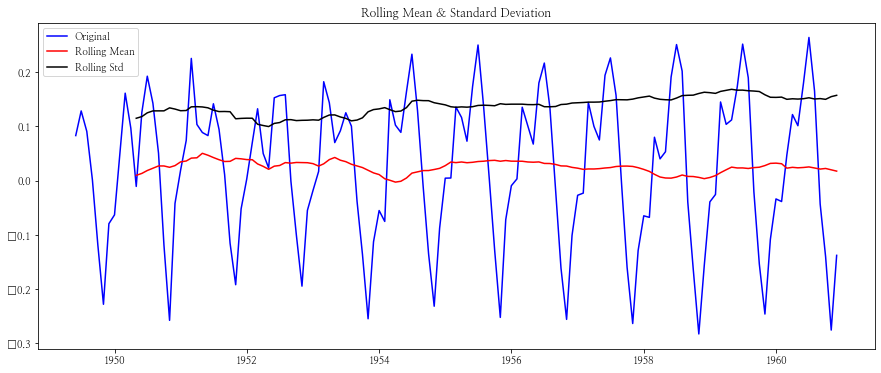

In [24]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg_6)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

# moving average를 고려할 때 window크기 결정하는 것이 중요하다.

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


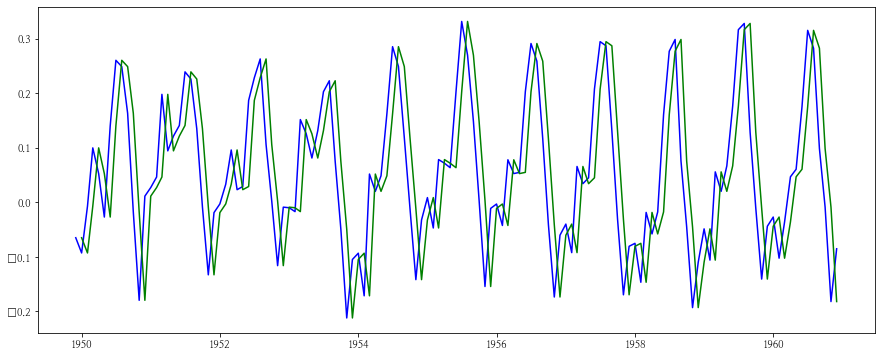

In [26]:
# 시계열 데이터 내에 파악되지 않은 주기적 변화를 예측에 방해되는 요소.
# 계절적, 주기적 패턴을 Seasonality라 한다.
# 이런 패턴을 상쇄하기 위한 방법에는 차분이 있다.

# 한 스텝 이동 후 이전 스텝과의 차분, 이번 스텝에서 발생한 변화량?
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

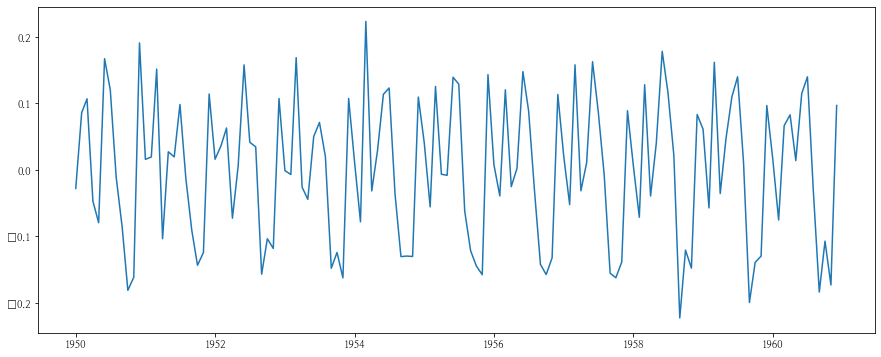

In [27]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

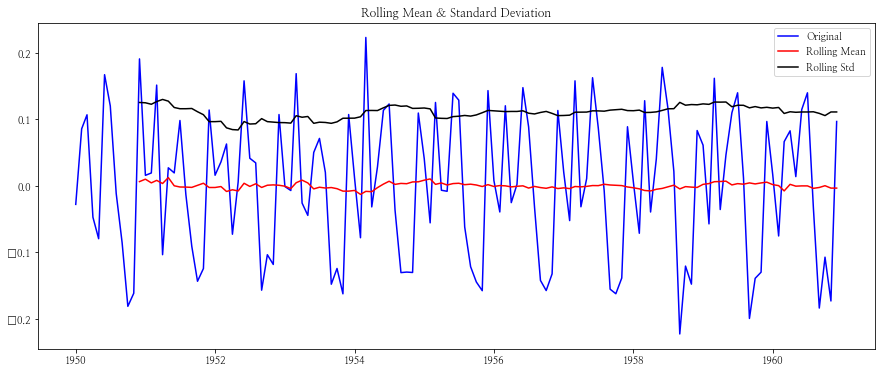

In [28]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [29]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

# p-value가 0.001정도까지 떨어진다.
# 1차 차분의 효과로 2차, 3차를 진행하면 더 떨어질 수도...

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


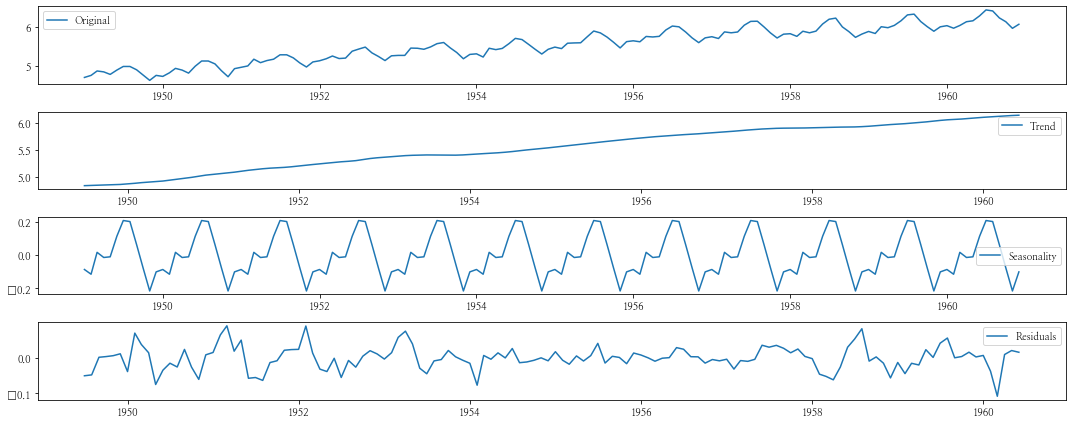

In [30]:
# statsmodels라이브러리에는 trend, seasonality를 분리하는 기능이 있다.
# moving average제거, differencing등 하지 않아도 분리 가능

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

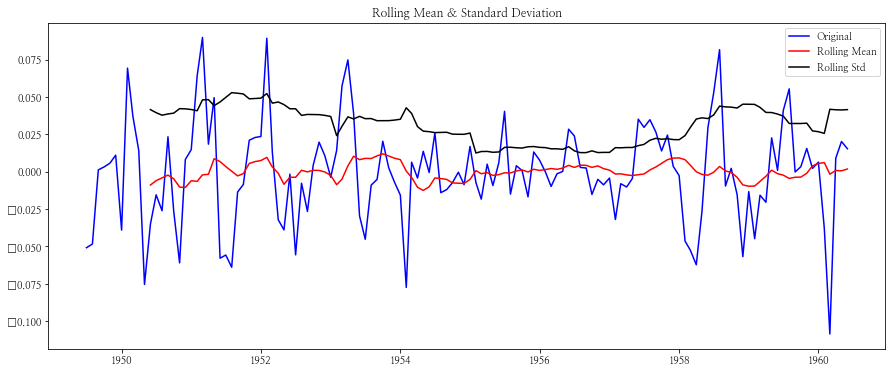

In [31]:
# original에서 trend와 seasonality를 제거한 나머지를 residual이라 한다.
# residual의 안정성은 어떠할까?

plot_rolling_statistics(residual)

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# residual를 쓰자.

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [ ]:
# 이런 과정을 한 번에 처리해주는 모델이 있다.
# ARIMA (AR(Autoregressive) + I(Integrated) + MA(Moving Average))
# AR(자기회귀) : 어떤 Y는 p개의 데이터의 가중합에 수렴한다고 본다.
# 일반적인 시계열에서 Trend와 Seasonality를 제거한 Residual에 해당하는 부분을
# 모델링한다고 볼 수 있다. 주식값 역시 항상 일정한 수준을 유지할 거라 예측하는 면에서
# AR로 모델링할 수 있다고 본다.

# MA(이동평균) : 어떤 Y는 q개의 예측오차값의 가중합에 수렴한다고 본다.
# 이는 일반적인 시계열에서 Trend을 모델링할 수 있다고 본다.
# 예측오차값이 + 이면 모델 예측보다 관측값이 더 높았다는 뜻이므로 다음 Y을 예측할 시
# 예측값을 올려잡게 된다. 주식값에서 항상 최근의 증감 패턴이 지속될 것이라 예측한 것이 본다.

# I(차분 누적) : 어떤 Y는 이전 데이터와 d차 차분누적합이라 보는 모델이다.
# 일반적인 시계열에서 Seasonality을 모델링할 수 있다고 본다.

# ARIMA는 3개의 모수(p, d, q)를 가진다.
# 통산 p + q < 2, p * q = 0인 값을 가지는데, 이는 p와 q중 하나는 0이라는 뜻이다.
# 실제 시계열 데이터는 AR이나 MA중 하나의 경향만 띠기 때문에 이렇게 한다.
# p, d, q는 ACF와 PACF를 통해 결정할 수 있다
# ACF는 시차에 따른 관측치들 사이의 관련성을 측정하는 함수
# PACF는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


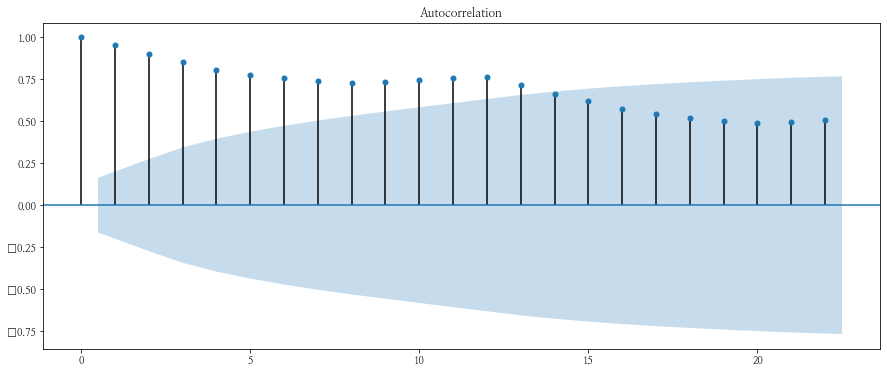

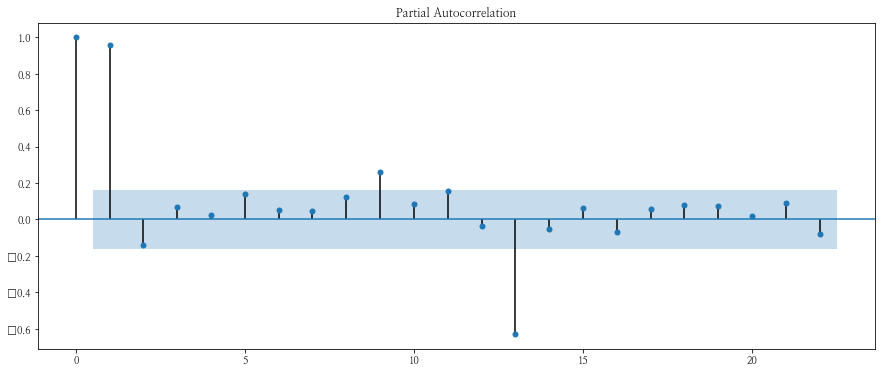

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# ACF를 통해 MA모델의 시차 q를 결정
# PACF를 통해 AR모델의 시차 p를 결정
# p = 1 결정, p가 2이상부터 PACF는 거의 0에 가까워짐.
# 0이란 현재 데이터와 p시점의 이전 데이터와의 상관도가 0, 즉 아무 상관이 없다는 뜻
# AR에서 q값은 특정될 수 없지만 바꿔 가보는 것도 좋음.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


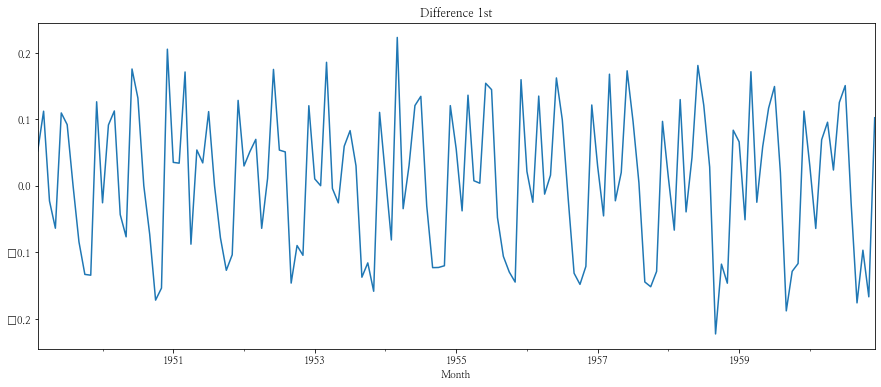

In [34]:
# d는 차분을 구해보면서 결정한다.
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


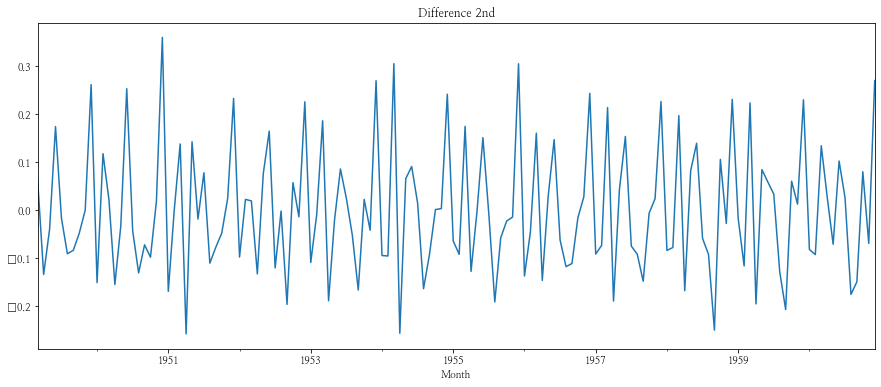

In [35]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 2차가 안정적이지만 1로 먼저 시도해보고 바꿔 가보자.

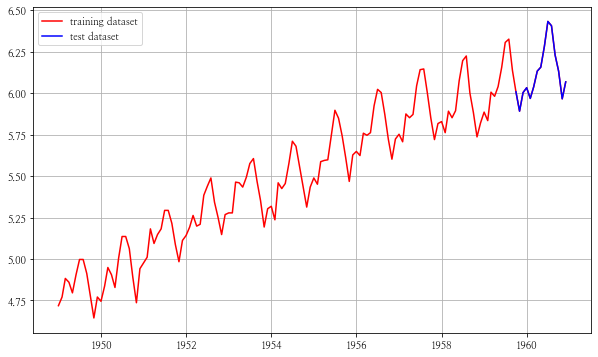

In [36]:
# 학습데이터 분리하기
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [37]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


In [46]:
# 우선 p = 1, d = 1, q = 0 로 결정
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Thu, 13 Aug 2020   AIC                           -210.046
Time:                        16:30:22   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


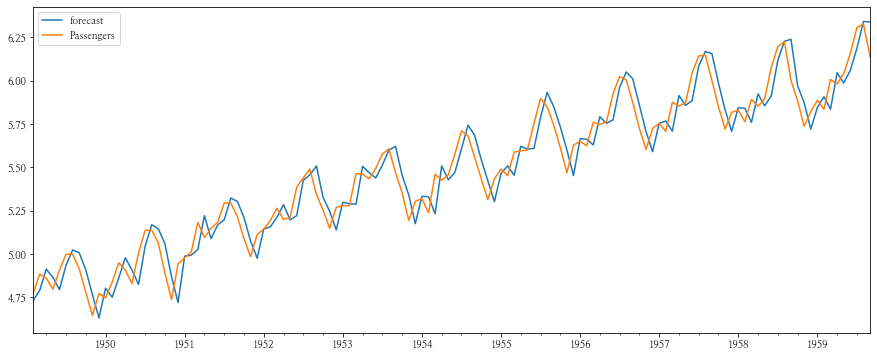

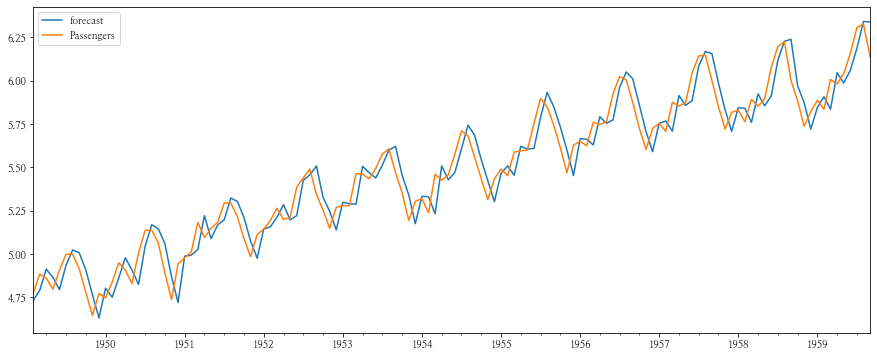

In [47]:
fitted_m.plot_predict()

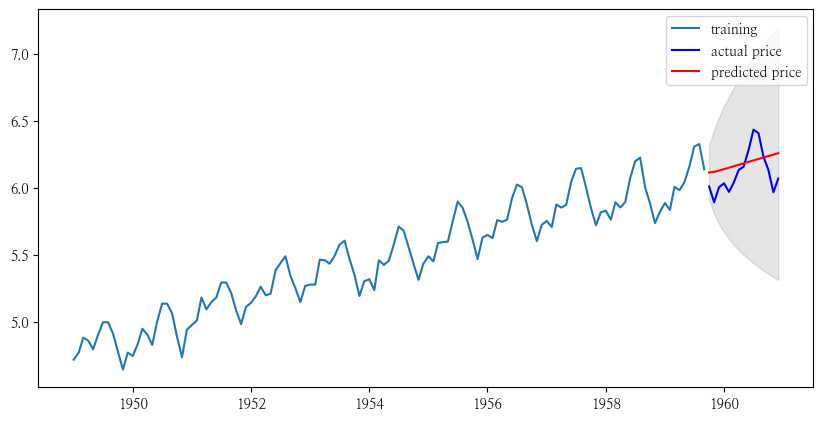

In [48]:
# forecast() 테스트 데이터 구간의 데이터 예측해보기
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [49]:
# 최종적인 모델의 오차율을 계산하려면 로그 변환된 데이터를 사용해왔으므로
# 모두 지수 변환하여 원본 스케일로 계산해야 한다.
# np.exp()로 돌린 후, MSE, MAE, RMSE, MAPE 계산

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# MAPE기준으로 14%정도의 오차율을 보인다.
# 모수를 조정하여 q=8일 경우 10%정도 개선, 데이터셋이 너무 작을 경우 무작정 올릴 수 없다.

MSE:  5409.54942893038
MAE:  63.1369176973685
RMSE:  73.54963921686074
MAPE: 14.08%
